<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [36]:
!pip3 -q install transformers
!pip3 -q install datasets

     |████████████████████████████████| 5.8 MB 10.0 MB/s 
     |████████████████████████████████| 7.6 MB 49.3 MB/s 
     |████████████████████████████████| 182 kB 69.9 MB/s 
     |████████████████████████████████| 451 kB 16.3 MB/s 
     |████████████████████████████████| 212 kB 72.1 MB/s 
     |████████████████████████████████| 132 kB 66.1 MB/s 
     |████████████████████████████████| 127 kB 74.1 MB/s 


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import keras
from keras_preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Mounted at /content/drive
/content/drive/My Drive/Challenge2


In [39]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

df_train.head()

,Unnamed: 0,data,label,target_name
0,0,Au 22e jour consécutif de la grève reconductib...,0,News
1,1,"Depuis plusieurs mois, les initiatives des che...",0,News
2,2,Google vient d'introduire une mise à jour de...,0,News
3,3,Portrait. Chacun s’empresse autour d’elle tan...,0,News
4,4,« Il n’y a pas de risque de pénurie » de carbu...,0,News


In [40]:
df_train.isna().sum()

Unnamed: 0     0
data           0
label          0
target_name    0
dtype: int64

In [41]:
df_test.isna().sum()

Unnamed: 0     0
data           0
label          0
target_name    0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


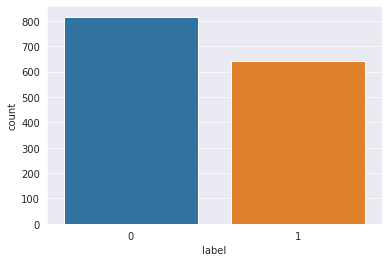

In [42]:
#Jeu de données en équilibre ou non

sns.set_style("darkgrid")
sns.countplot(df_train.label)

In [43]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

df_train.head()

,data,label
0,Au 22e jour consécutif de la grève reconductib...,0
1,"Depuis plusieurs mois, les initiatives des che...",0
2,Google vient d'introduire une mise à jour de...,0
3,Portrait. Chacun s’empresse autour d’elle tan...,0
4,« Il n’y a pas de risque de pénurie » de carbu...,0


In [44]:
STOPWORDS = set(stopwords.words('french'))

def cleaner(text):
    text = text.lower()
    #removing square brackets
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    #removing URL's
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #removing <>
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [45]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

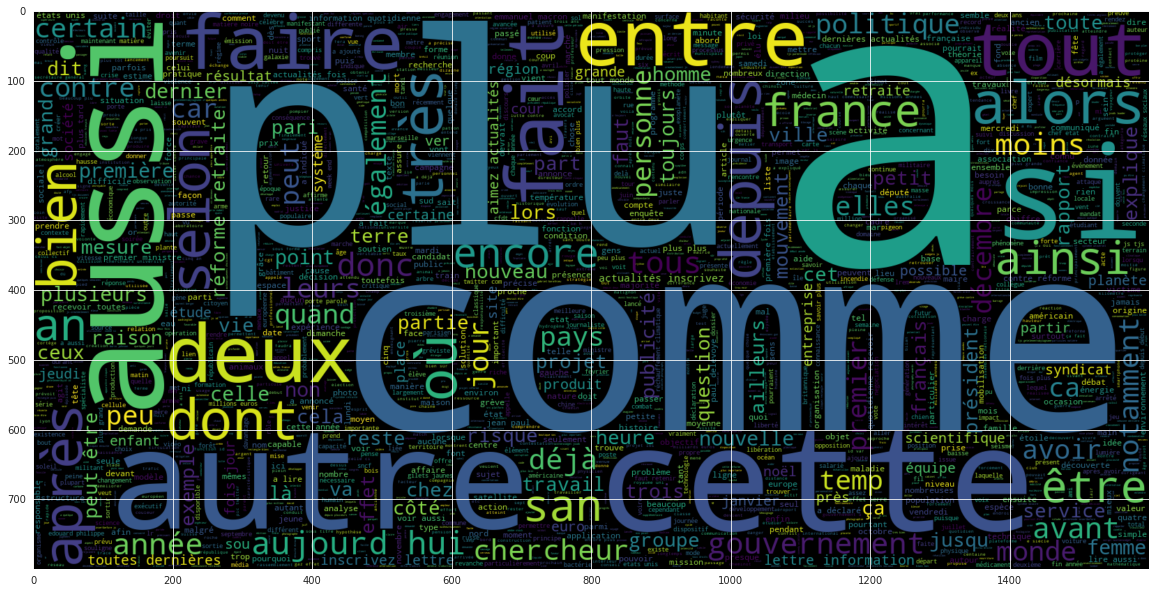

In [46]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_train[df_train.label == 0].data))
plt.imshow(wc , interpolation = 'bilinear')

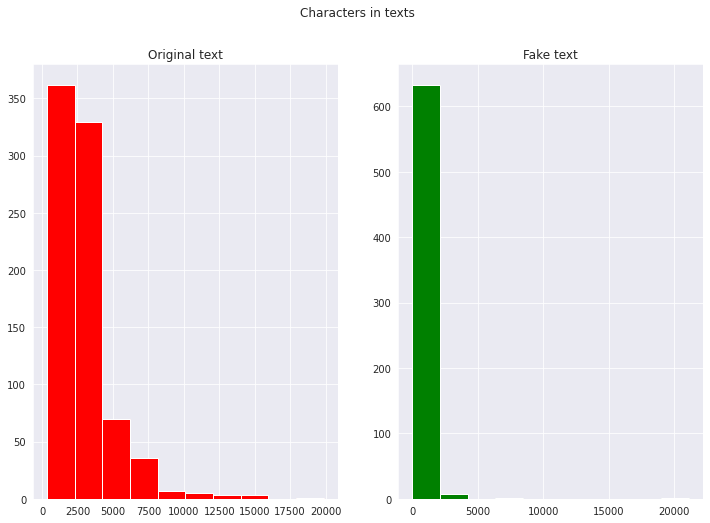

In [47]:
#Nombre de characters dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df_train[df_train['label']==0]['data'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df_train[df_train['label']==1]['data'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

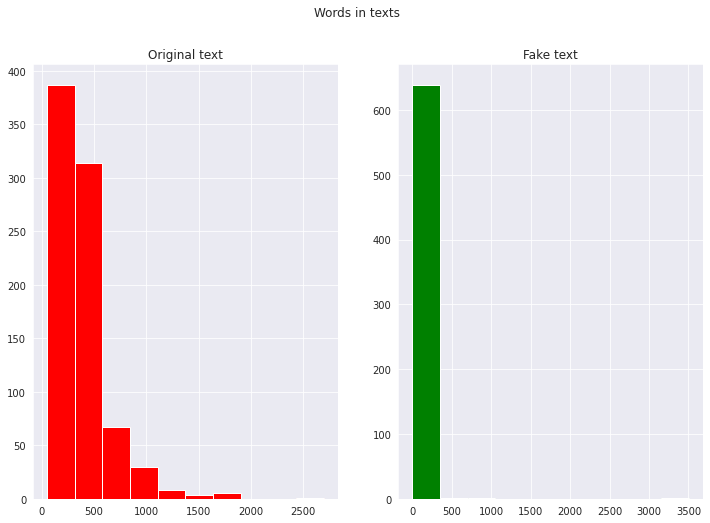

In [48]:
#Nombre de mots dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df_train[df_train['label']==0]['data'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df_train[df_train['label']==1]['data'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

Text(0.5, 0.98, 'Average word length in each text')

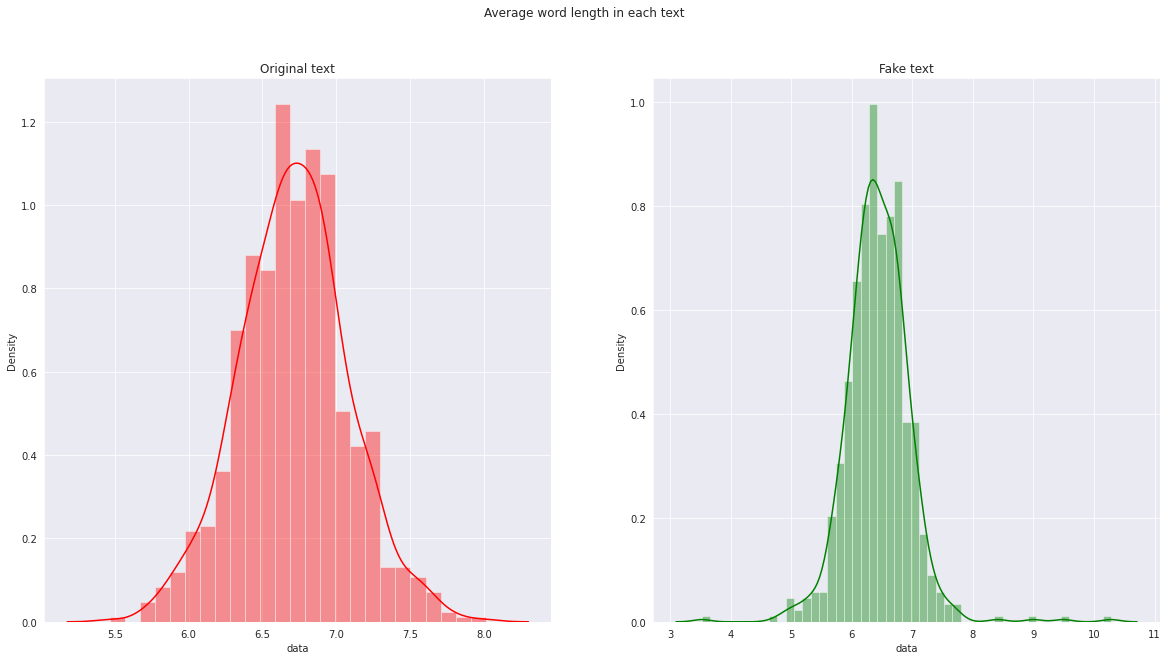

In [49]:
#Taille moyenne des mots dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df_train[df_train['label']==0]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df_train[df_train['label']==1]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [50]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_train.data)
corpus[:5]

['jour', 'consécutif', 'grève', 'reconductible', 'contre']

In [51]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'a': 7733,
 'plus': 3814,
 'islam': 3471,
 'cette': 1839,
 'comme': 1653,
 'aussi': 1406,
 'être': 1369,
 'tout': 1323,
 'fait': 1281,
 'deux': 1128}

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

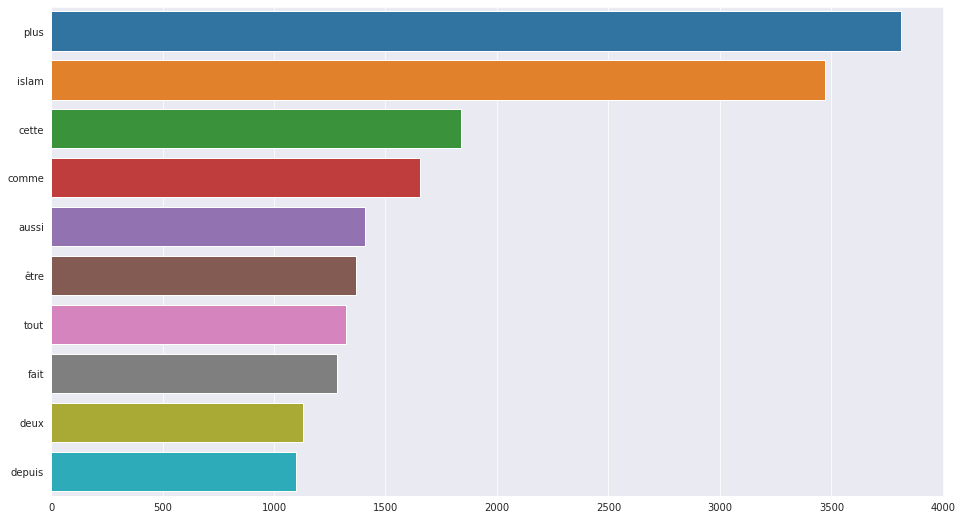

In [53]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df_train.data,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

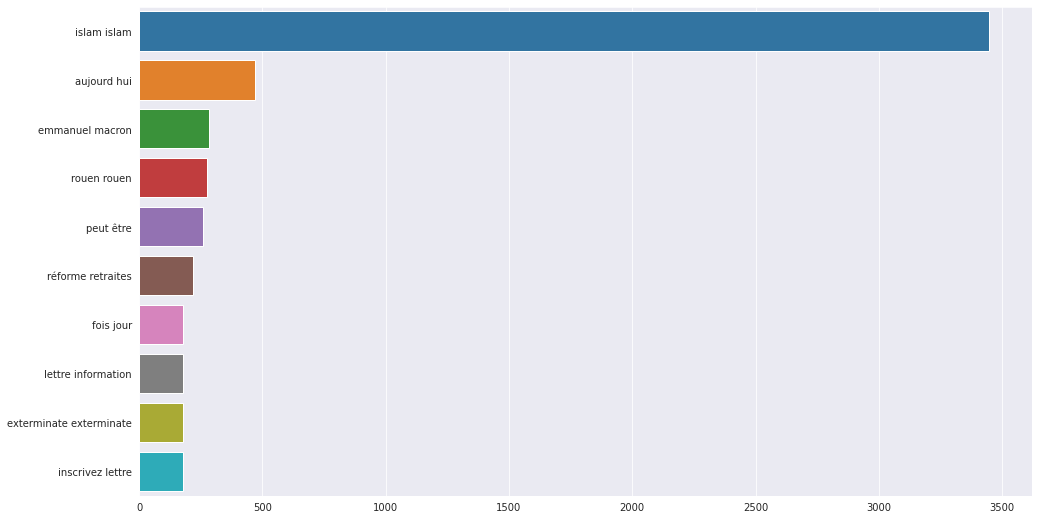

In [54]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df_train.data,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

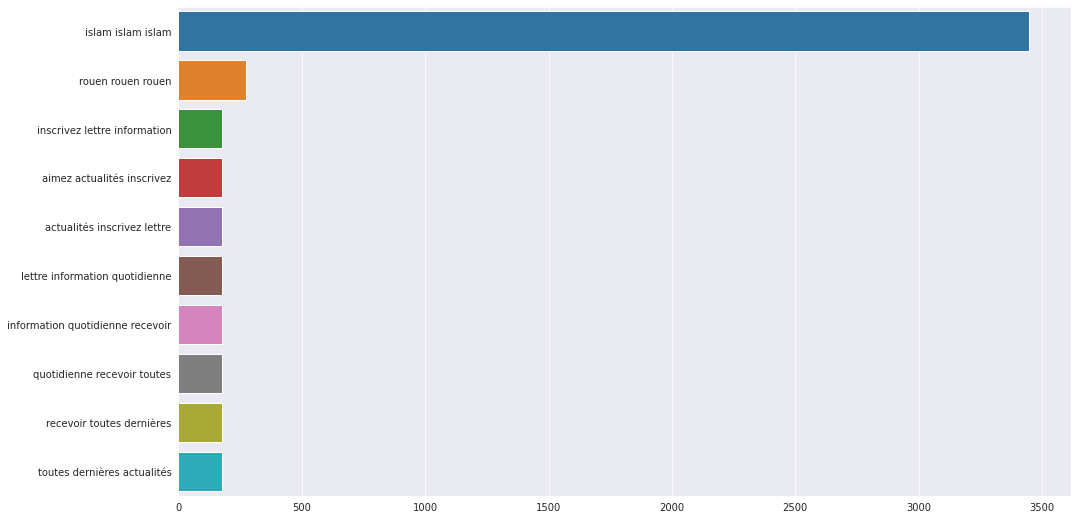

In [55]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df_train.data,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

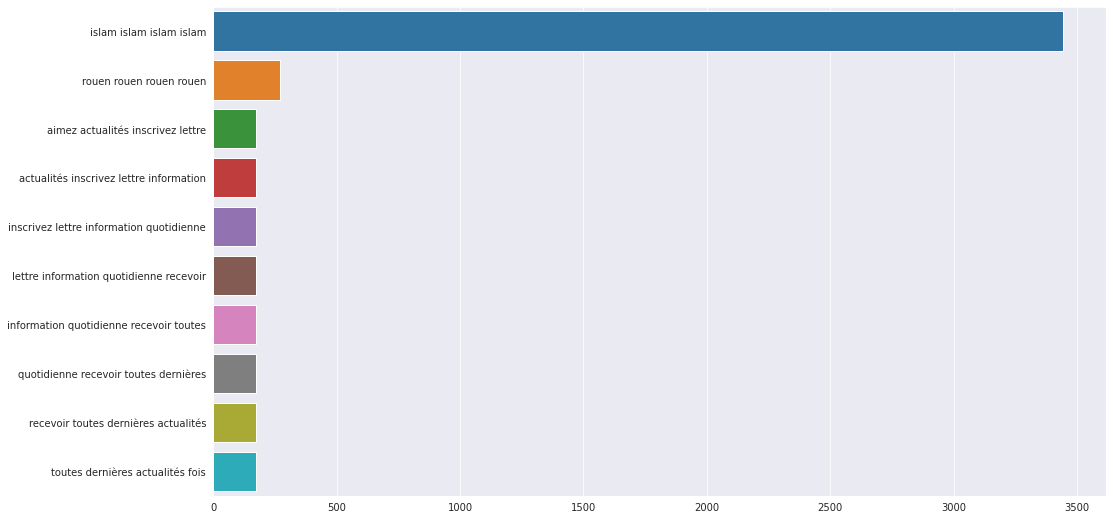

In [56]:
plt.figure(figsize = (16,9))
most_common_quad = get_top_text_ngrams(df_train.data,10,4)
most_common_quad = dict(most_common_quad)
sns.barplot(x=list(most_common_quad.values()),y=list(most_common_quad.keys()))

In [57]:
x_train = df_train["data"]
y_train = df_train["label"]

x_test = df_test["data"]
y_test = df_test["label"]

In [58]:
max_features = 10000
maxlen = 512

In [59]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [60]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [74]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open("!!!!!!!!!!!!!!!")

SyntaxError: ignored

In [75]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

NameError: ignored

In [76]:
batch_size = 32
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [77]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer 
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

NameError: ignored

In [73]:
model.build()
model.summary()

ValueError: ignored

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
model.save()

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")